In [1]:
import os
import json
from datetime import timedelta

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [6]:
plt.style.use("seaborn-v0_8")
sns.set_palette("muted")

In [7]:
# Loading data
df = pd.read_csv("data.csv", encoding="ISO-8859-1")

In [8]:
# Normalizing the column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

In [9]:
#EDA
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())

Dataset shape: (541909, 8)

First 5 rows:
   invoiceno stockcode                          description  quantity     invoicedate  unitprice  customerid         country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6  12/1/2010 8:26       2.55     17850.0  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6  12/1/2010 8:26       3.39     17850.0  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8  12/1/2010 8:26       2.75     17850.0  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6  12/1/2010 8:26       3.39     17850.0  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6  12/1/2010 8:26       3.39     17850.0  United Kingdom


In [10]:
print("\nData types and null counts:\n")
df.info()


Data types and null counts:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   invoiceno    541909 non-null  object 
 1   stockcode    541909 non-null  object 
 2   description  540455 non-null  object 
 3   quantity     541909 non-null  int64  
 4   invoicedate  541909 non-null  object 
 5   unitprice    541909 non-null  float64
 6   customerid   406829 non-null  float64
 7   country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [11]:
# Missing Data 
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    "Missing Values": missing_data,
    "Percentage": missing_percent
})
print("\nMissing Data Summary:\n", missing_summary)


Missing Data Summary:
              Missing Values  Percentage
customerid           135080   24.926694
description            1454    0.268311
invoiceno                 0    0.000000
stockcode                 0    0.000000
quantity                  0    0.000000
invoicedate               0    0.000000
unitprice                 0    0.000000
country                   0    0.000000


In [12]:
# Duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())


Number of duplicate rows: 5268


In [13]:
# Unique values
unique_counts = df.nunique().sort_values(ascending=False)
print("\nUnique values per column:\n", unique_counts)


Unique values per column:
 invoiceno      25900
invoicedate    23260
customerid      4372
description     4223
stockcode       4070
unitprice       1630
quantity         722
country           38
dtype: int64


In [14]:
# Summary stats
print("\nSummary statistics for numeric columns:\n", df.describe())


Summary statistics for numeric columns:
             quantity      unitprice     customerid
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


In [15]:
# Top countries by transactions
print("\nTop 10 Countries by transaction count:\n", df['country'].value_counts().head(10))


Top 10 Countries by transaction count:
 country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: count, dtype: int64


In [17]:
# Data Cleaning
# Drop rows with missing essential values
df.dropna(subset=["invoiceno", "invoicedate", "unitprice", "quantity"], inplace=True)

In [18]:
# Fill missing customerid with 'Unknown'
df["customerid"] = df["customerid"].fillna("Unknown")

In [20]:
# Remove duplicates
df = df.drop_duplicates()

In [21]:
# Converting the data types
df["invoicedate"] = pd.to_datetime(df["invoicedate"], errors="coerce")
df["unitprice"] = pd.to_numeric(df["unitprice"], errors="coerce")
df["quantity"] = pd.to_numeric(df["quantity"], errors="coerce")

In [23]:
# Flag returns (quantity < 0)
df["is_return"] = df["quantity"] < 0

In [24]:
# Handle outliers in unit price
price_threshold = df["unitprice"].quantile(0.999)
df.loc[df["unitprice"] > price_threshold, "unitprice"] = price_threshold

In [25]:
# Derived fields
df["line_total"] = df["quantity"] * df["unitprice"]
df["invoice_month"] = df["invoicedate"].dt.to_period("M")

print("\nShape after cleaning:", df.shape)


Shape after cleaning: (536641, 11)


In [26]:
# Statistical Analysis
# Descriptive stats
print("\nDescriptive statistics for cleaned data:\n", df[["quantity", "unitprice", "line_total"]].describe())


Descriptive statistics for cleaned data:
             quantity      unitprice     line_total
count  536641.000000  536641.000000  536641.000000
mean        9.620029       3.613789      18.414663
std       219.130156      23.130436     365.136832
min    -80995.000000  -11062.060000 -168469.600000
25%         1.000000       1.250000       3.750000
50%         3.000000       2.080000       9.870000
75%        10.000000       4.130000      17.400000
max     80995.000000     207.908800  168469.600000


In [31]:
df = df[(df['unitprice'] > 0) & (df['quantity'] > 0)]

In [32]:
print("Shape after removing invalid prices/quantities:", df.shape)

Shape after removing invalid prices/quantities: (524878, 11)


In [33]:
desc_stats = df[['quantity', 'unitprice', 'line_total']].describe()
print("\nDescriptive statistics after removing invalid rows:\n", desc_stats)


Descriptive statistics after removing invalid rows:
             quantity      unitprice     line_total
count  524878.000000  524878.000000  524878.000000
mean       10.616600       3.571500      19.874559
std       156.280031       7.975809     264.566456
min         1.000000       0.001000       0.001000
25%         1.000000       1.250000       3.900000
50%         4.000000       2.080000       9.920000
75%        11.000000       4.130000      17.700000
max     80995.000000     207.908800  168469.600000


In [34]:
# Correlation analysis
corr_matrix = df[["quantity", "unitprice", "line_total"]].corr(method="pearson")
print("\nCorrelation matrix:\n", corr_matrix)


Correlation matrix:
             quantity  unitprice  line_total
quantity    1.000000  -0.014475    0.931867
unitprice  -0.014475   1.000000    0.033834
line_total  0.931867   0.033834    1.000000


In [35]:
# Hypothesis Test to compare mean unit price UK vs Non-UK
uk_prices = df.loc[df["country"] == "United Kingdom", "unitprice"]
non_uk_prices = df.loc[df["country"] != "United Kingdom", "unitprice"]
t_stat, p_val = stats.ttest_ind(uk_prices, non_uk_prices, equal_var=False)
print("\nT-test UK vs Non-UK mean unit prices:")
print("t-statistic:", t_stat, " | p-value:", p_val)


T-test UK vs Non-UK mean unit prices:
t-statistic: -3.9664173183442264  | p-value: 7.305728507140234e-05


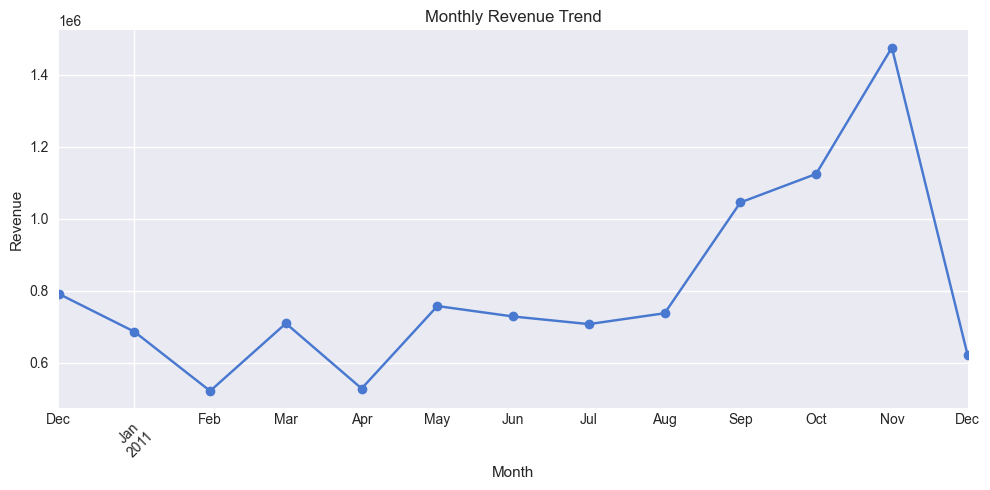

In [36]:
# For visualization

# Monthly revenue
monthly_revenue = df.groupby("invoice_month")["line_total"].sum()
plt.figure(figsize=(10,5))
monthly_revenue.plot(marker="o")
plt.title("Monthly Revenue Trend")
plt.ylabel("Revenue")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("monthly_revenue.png")
plt.show()

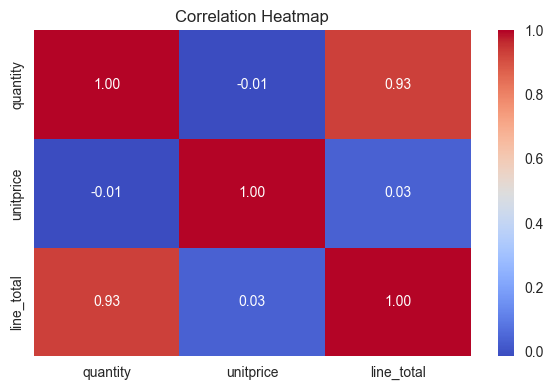

In [37]:
# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

In [38]:
# RFM Analysis

# Reference date
snapshot_date = df["invoicedate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("customerid").agg({
    "invoicedate": lambda x: (snapshot_date - x.max()).days,
    "invoiceno": "nunique",
    "line_total": "sum"
})
rfm.rename(columns={"invoicedate":"Recency","invoiceno":"Frequency","line_total":"Monetary"}, inplace=True)


In [39]:
# Standardize
rfm_log = np.log1p(rfm)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(rfm_log)

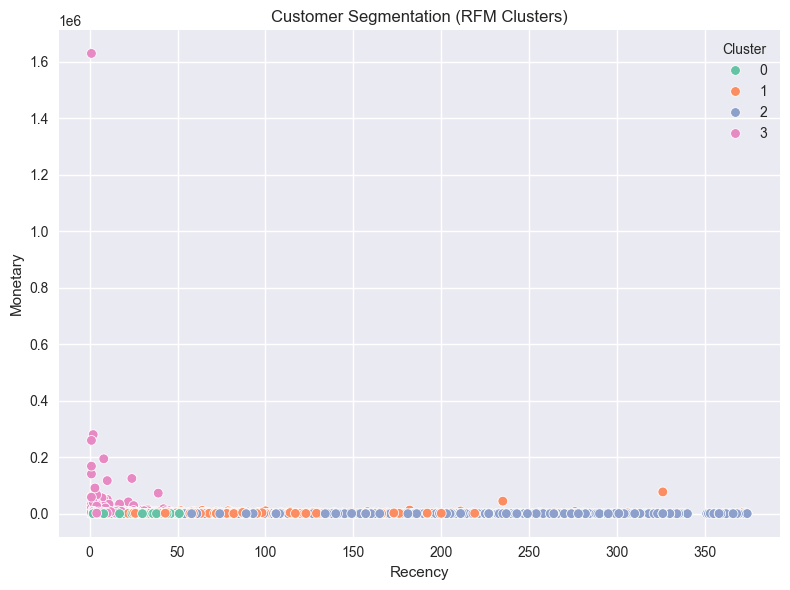

In [40]:
# Scatterplot
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="Cluster", palette="Set2")
plt.title("Customer Segmentation (RFM Clusters)")
plt.tight_layout()
plt.savefig("rfm_clusters.png")
plt.show()

In [41]:
df.to_csv("cleaned_data.csv", index=False)
rfm.to_csv("rfm_clustered.csv")

In [42]:
analysis_report = {
    "dataset_shape": df.shape,
    "missing_data_summary": missing_summary.to_dict(),
    "duplicates_removed": int(df.duplicated().sum()),
    "correlation_matrix": corr_matrix.to_dict(),
    "t_test": {
        "t_stat": float(t_stat),
        "p_value": float(p_val)
    },
    "plots": {
        "monthly_revenue": "monthly_revenue.png",
        "correlation_heatmap": "correlation_heatmap.png",
        "rfm_clusters": "rfm_clusters.png"
    },
    "insights": {
        "missing_customerid_percent": float(missing_percent.get("customerid", 0)),
        "return_rate_percent": float(100 * df["is_return"].mean()),
        "highest_revenue_month": str(monthly_revenue.idxmax()),
        "top_country_by_txn": str(df['country'].value_counts().idxmax())
    }
}

In [43]:
with open("analysis_report.json", "w") as f:
    json.dump(analysis_report, f, indent=4)

print("\nAnalysis report saved to analysis_report.json")


Analysis report saved to analysis_report.json
